# Model 3: ensemble methods

In [1]:
from __future__ import division

In [2]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report, fbeta_score
from sklearn.metrics import , accuracy_score, roc_auc_score, roc_curve, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.base import clone

# Import visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Import functions from own Python-File (see visuals.py in Repo)
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

In [3]:
# Loading dataset and dropping the first column, because it contains rownumbers
data = pd.read_csv('data/Kickstarter_cleaned2.csv')
df = data.drop(columns=["Unnamed: 0","backers_count","id","usd_pledged","category_name","category_id",
                       "month_deadline","weekday_deadline","weekday_launched_at",
                       "country_US_True"])
df.columns

Index(['category_parent_id', 'usd_goal', 'duration_days', 'duration_days_prep',
       'year_deadline', 'winter_deadline_True', 'spring_deadline_True',
       'summer_deadline_True', 'deadline_weekend_True',
       'launched_weekend_True', 'eastcoast_True', 'long_blurb_True',
       'long_name_True', 'state_b_True', 'long_creator_name_True'],
      dtype='object')

## Models: decision trees, random forest and adaboost.

In [4]:
# Defining X and y
y = df.state_b_True
X = df.drop(columns='state_b_True')

# Splitting data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [5]:
# Define columns to scale
col_scale = ['category_parent_id','usd_goal', 'duration_days','duration_days_prep',
             'year_deadline']

# Scale columns
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train[col_scale])
X_test_scaled = scaler.transform(X_test[col_scale])

# Concatenating scaled and dummy columns 
X_train_preprocessed = np.concatenate([X_train_scaled, X_train.drop(col_scale, axis=1)], axis=1)
X_test_preprocessed = np.concatenate([X_test_scaled, X_test.drop(col_scale, axis=1)], axis=1)

X_train = X_train_preprocessed
X_test = X_test_preprocessed

In [6]:
# General function for fitting models, making predictions with these models 
# and for checking the duration of the computations

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set,
    #then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta=0.5)
        
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=0.5)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [7]:
# Defining the three models and running the train_predict function

# Initialize the three models, the random states are set to 101 so we know how to reproduce the model later
clf_A = DecisionTreeClassifier(random_state=42)
clf_B = RandomForestClassifier(n_estimators=100, 
                               random_state=42, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)
clf_C = AdaBoostClassifier(random_state = 42)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_50 = int(round(len(X_train) / 2))
samples_100 = len(X_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_50, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

DecisionTreeClassifier trained on 58167 samples.
DecisionTreeClassifier trained on 116334 samples.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


RandomForestClassifier trained on 58167 samples.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


RandomForestClassifier trained on 116334 samples.
AdaBoostClassifier trained on 58167 samples.
AdaBoostClassifier trained on 116334 samples.


## Results

In [13]:
#Printing out the values for each model in a data frame
for i in results.items():
    print (i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'50%', 1:'100%'}))

DecisionTreeClassifier


,50%,100%
train_time,0.239405,0.538764
pred_time,0.014795,0.016815
acc_train,0.996667,0.996667
acc_test,0.640519,0.650467
f_train,0.998804,0.998804
f_test,0.678424,0.687152


RandomForestClassifier


,50%,100%
train_time,1.229258,2.794599
pred_time,0.240442,0.326389
acc_train,0.996667,0.996667
acc_test,0.714890,0.715432
f_train,0.998804,0.998804
f_test,0.736389,0.736408


AdaBoostClassifier


,50%,100%
train_time,1.242432,2.625388
pred_time,0.226104,0.235090
acc_train,0.710000,0.720000
acc_test,0.715693,0.717758
f_train,0.732379,0.743243
f_test,0.739205,0.741170


The random forest model and the adaboost model perform better than the decision tree model. The *accuracy score* on the test data and the *f1_score* on the test data is marginally better for the **adaboost** model than for the random forest model.

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


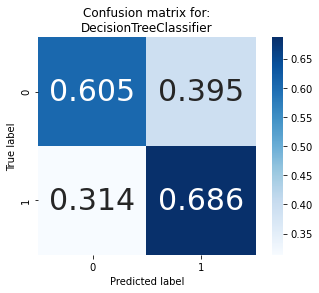

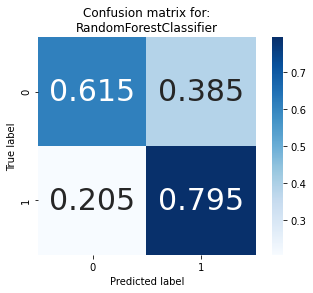

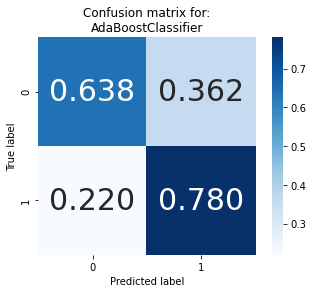

In [14]:
#Visualizing the confusion matrix for each classifier

for i,model in enumerate([clf_A,clf_B,clf_C]):
    cm = confusion_matrix(y_test, model.predict(X_test))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

    # view with a heatmap
    plt.figure(i)
    sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));

The **confusion matrices** show that the *random forest* model performs better at classifying *true successes* and the *adaboost* model performs better at classifying *true failures*.

In [17]:
# Find the best estimator using GridSearchCV 
# and compare the optimized model to the unoptimized one.

# Initialize the classifier
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier()) 

# Create the parameters list you wish to tune
parameters = {'n_estimators':[50, 100],                
              'learning_rate':[0.1, 0.5, 1.],               
              'base_estimator__min_samples_split' : np.arange(2, 8, 2),               
              'base_estimator__max_depth' : np.arange(1, 4, 1)              
             } 

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score,beta=0.5) 

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scorer, verbose=1, n_jobs=-1)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train) 

# Get the estimator
best_clf = grid_fit.best_estimator_ 

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test) 

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print(best_clf)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/Users/jakoliendenhollander/opt/anaconda3/envs/kickstarter/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass scoring=make_scorer(fbeta_score, beta=0.5) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  7.0min finished


Unoptimized model
------
Accuracy score on testing data: 0.6971
F-score on testing data: 0.7239

Optimized Model
------
Final accuracy score on the testing data: 0.7373
Final F-score on the testing data: 0.7551
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.5, n_estimators=100)


The accuracy and the F1 score of the **optimized model** is better than these scores of the unoptimized model.

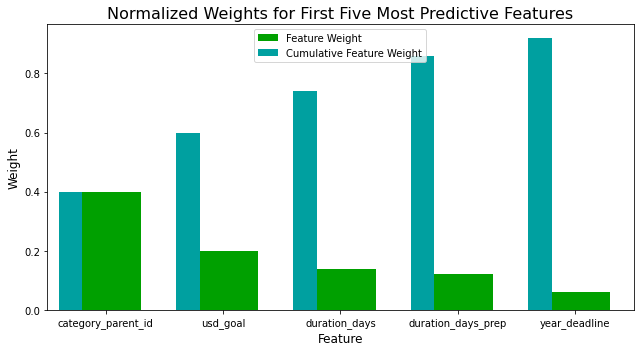

In [18]:
# Get the five most predictive features

# Train the supervised model on the training set 
model = AdaBoostClassifier().fit(X_train,y_train)

# Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

The **five most predicitive features** of the model are the parent id of the category, the goal in USD, the duration of the project between the launch and the deadline, the number of days used for preparation between the creation and the launch of the project and the year of the deadline.

In [19]:
# Compare the optimal model on the full data and on the reduced data.

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.7373
F-score on testing data: 0.7551

Final Model trained on reduced data
------
Accuracy on testing data: 0.7338
F-score on testing data: 0.7526


The model only performs slightly better on the **full data** than on the reduced data.